In [537]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [538]:
# Shared functions

In [539]:
def convert_to_boolean_labels(labels):
    return np.where(labels >= 0.5, True, False)

In [540]:
def scatterplot(results, model_1, model_2, y_label, ylim=(0.8, 1.0)):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    #bar_width = 0.35
    point_size=15
    for i, (_index, row) in enumerate(results.iterrows()):
        # For each subgroup, we plot a 1D scatterplot. The x-value is the position
        # of the item in the dataframe. To change the ordering of the subgroups,
        # sort the dataframe before passing to this function.
        x = [i] * 2
        y = [row[model_1], row[model_2]]
        ax.scatter(x, y, s=0)
        #if (abs(y[1] - y[0]) > 0.003):
        plt.arrow(x[0],y[0], 0, y[1] - y[0], length_includes_head=True, shape='full', head_starts_at_zero=False, head_length=0.005, head_width=0.3, color='black')
    ax.set_xticklabels(results['subgroup'], rotation=90)
    ax.set_xticks(range(len(results)))
    ax.set_ylim(ylim)
    ax.set_title(y_label)
    fig.tight_layout()
    #fig.savefig('/tmp/%s_%s.eps' % (file_name, values_col), format='eps')

In [541]:
# MADLIBS set up

In [542]:
model_families = [
    ['Rock:TOXICITY'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['RockV5_1:TOXICITY'],# 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
    ['RockV6_1:TOXICITY'],
]

In [543]:
madlibs = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')

In [544]:
# Add columns for each subgroup.
f = open('bias_madlibs_data/adjectives_people.txt', 'r')
terms = [line.strip() for line in f]
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'Text', terms)

In [545]:
madlibs['label_bool'] = madlibs.apply(lambda row: row.Label == 'BAD', axis=1)

In [546]:
madlibs_results = model_bias_analysis.per_subgroup_aucs(madlibs, terms, model_families, 'label_bool')

In [547]:
madlibs_results['TOXICITY_V1_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_negative_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_negative_label_mwus'][0], axis=1)

madlibs_results['TOXICITY_V1_positive_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_positive_label_mwus'][0], axis=1)

In [548]:
# Real Data set up 

In [549]:
human_labels = [
 'toxicity',
 'severe_toxicity',
 'obscene',
 'sexual_explicit',
 'identity_attack',
 'insult',
 'threat',
 'male',
 'female',
 'transgender',
 'other_gender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'other_sexual_orientation',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness',
 'other_disability']

identities = [
 'male',
 'female',
 'transgender',
 'heterosexual',
 'homosexual_gay_or_lesbian',
 'bisexual',
 'christian',
 'jewish',
 'muslim',
 'hindu',
 #'buddhist',
 'atheist',
 'other_religion',
 'black',
 'white',
 'asian',
 'latino',
 'other_race_or_ethnicity',
 #'physical_disability',
 'intellectual_or_learning_disability',
 'psychiatric_or_mental_illness']

In [550]:
real_data = pd.read_csv('eval_datasets/identity_labeled_scored.csv')

In [551]:
real_data_model_families = [
    ['rock_toxicity'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['rock_v6_1_toxicity'],# 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
]

In [552]:
for human_label in human_labels:
    real_data[human_label] = convert_to_boolean_labels(real_data[human_label])

In [553]:
real_data = real_data[(real_data.comment_text.str.len() < 100)]

In [564]:
len(real_data)

482392

In [554]:
real_data_results = model_bias_analysis.per_subgroup_aucs(real_data, identities, real_data_model_families, 'toxicity')

In [555]:
real_data_results['TOXICITY_V1_pinned_auc'] = real_data_results.apply(lambda row: row['rock_toxicity_aucs'][0], axis=1)
real_data_results['TOXICITY_V6_pinned_auc'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_aucs'][0], axis=1)

real_data_results['TOXICITY_V1_weighted_pinned_auc'] = real_data_results.apply(lambda row: row['rock_toxicity_normalized_pinned_aucs'][0], axis=1)
real_data_results['TOXICITY_V6_weighted_pinned_auc'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_normalized_pinned_aucs'][0], axis=1)

real_data_results['TOXICITY_V1_negative_aeg'] = real_data_results.apply(lambda row: row['rock_toxicity_within_negative_label_mwus'][0], axis=1)
real_data_results['TOXICITY_V6_negative_aeg'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_within_negative_label_mwus'][0], axis=1)

real_data_results['TOXICITY_V1_positive_aeg'] = real_data_results.apply(lambda row: row['rock_toxicity_within_positive_label_mwus'][0], axis=1)
real_data_results['TOXICITY_V6_positive_aeg'] = real_data_results.apply(lambda row: row['rock_v6_1_toxicity_within_positive_label_mwus'][0], axis=1)


In [556]:
# RESULTS

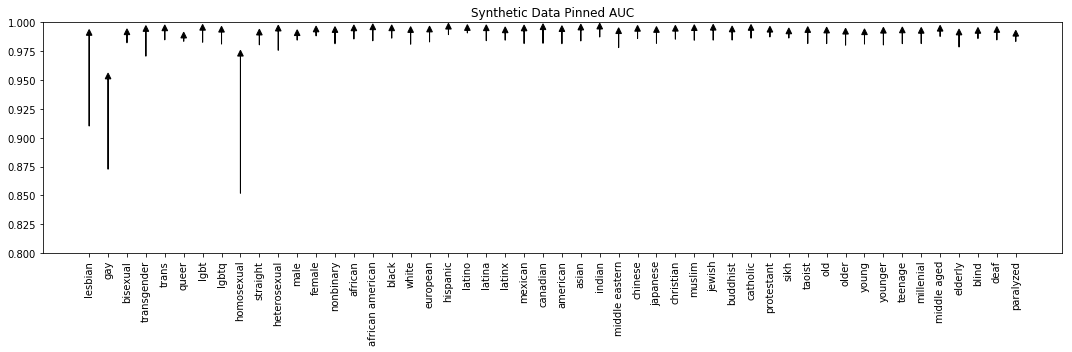

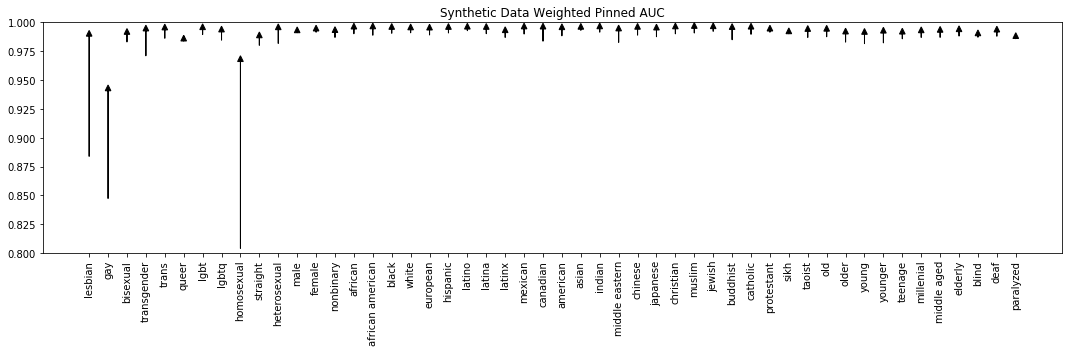

In [557]:
scatterplot(madlibs_results, 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'Synthetic Data Pinned AUC')
scatterplot(madlibs_results, 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'Synthetic Data Weighted Pinned AUC')

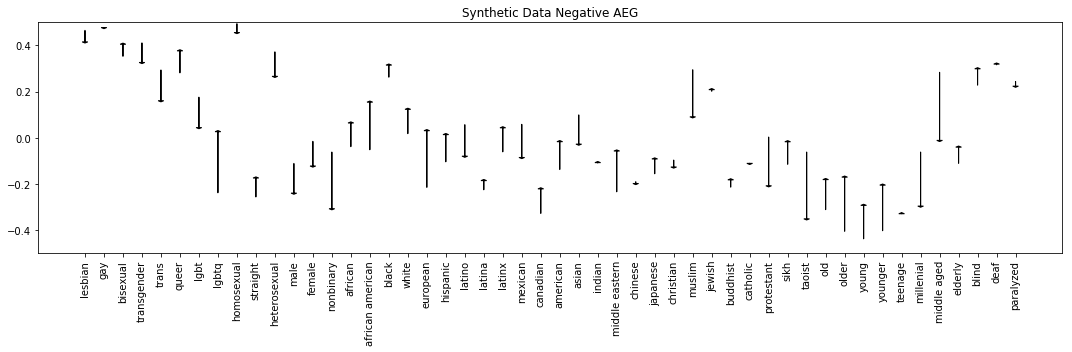

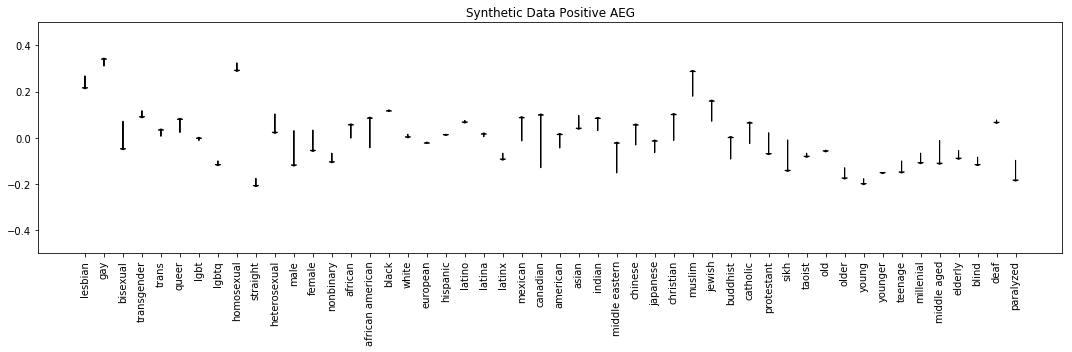

In [558]:
scatterplot(madlibs_results, 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'Synthetic Data Negative AEG', ylim=(-0.5,0.5))
scatterplot(madlibs_results, 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg', 'Synthetic Data Positive AEG', ylim=(-0.5,0.5))

In [559]:
# REAL DATA

In [562]:
real_data_results

,rock_toxicity_aucs,rock_toxicity_cross_subgroup_negative_mwus,rock_toxicity_cross_subgroup_positive_mwus,rock_toxicity_mean,rock_toxicity_median,rock_toxicity_normalized_pinned_aucs,rock_toxicity_std,rock_toxicity_within_negative_label_mwus,rock_toxicity_within_positive_label_mwus,rock_toxicity_within_subgroup_mwus,...,subgroup,subset_size,TOXICITY_V1_pinned_auc,TOXICITY_V6_pinned_auc,TOXICITY_V1_weighted_pinned_auc,TOXICITY_V6_weighted_pinned_auc,TOXICITY_V1_negative_aeg,TOXICITY_V6_negative_aeg,TOXICITY_V1_positive_aeg,TOXICITY_V6_positive_aeg
0,[0.927581157965],[0.914305221331],[0.942651241061],0.927581,0.927581,[0.921334608433],0.0,[0.131821150686],[-0.0359348581758],[0.907047362907],...,male,9802,0.927581,0.938213,0.921335,0.934817,0.131821,0.116113,-0.035935,-0.046970
1,[0.916684504728],[0.90175991396],[0.938139716106],0.916685,0.916685,[0.908443507178],0.0,[0.171703712689],[-0.0438539071988],[0.885430891466],...,female,8064,0.916685,0.927983,0.908444,0.923202,0.171704,0.176722,-0.043854,-0.038025
2,[0.855654761905],[0.827187038813],[0.92450590618],0.855655,0.855655,[0.830741610087],0.0,[0.336600373212],[-0.18114621614],[0.740531885269],...,transgender,366,0.855655,0.867607,0.830742,0.852357,0.336600,0.269150,-0.181146,-0.184134
3,[0.874149659864],[0.732533464018],[0.936726245788],0.874150,0.874150,[0.79675806752],0.0,[0.34195726863],[-0.0344767661836],[0.721014492754],...,heterosexual,116,0.874150,0.914966,0.796758,0.868248,0.341957,0.211226,-0.034477,-0.195629
4,[0.874574578478],[0.581074410681],[0.981098082677],0.874575,0.874575,[0.756916296546],0.0,[0.432370616468],[0.101268279671],[0.708576396281],...,homosexual_gay_or_lesbian,1502,0.874575,0.875795,0.756916,0.842627,0.432371,0.296942,0.101268,-0.081828
5,[0.897119341564],[0.824657534247],[0.936428118258],0.897119,0.897119,[0.862028550835],0.0,[0.327810037189],[-0.0876421991712],[0.825],...,bisexual,36,0.897119,0.860082,0.862029,0.886350,0.327810,0.178483,-0.087642,-0.186182
6,[0.929965172867],[0.933472034342],[0.928562064012],0.929965,0.929965,[0.924017233124],0.0,[0.123916449155],[-0.0891883770156],[0.910017601019],...,christian,4656,0.929965,0.939083,0.924017,0.935594,0.123916,0.091533,-0.089188,-0.108577
7,[0.89138948225],[0.798783305868],[0.953742247037],0.891389,0.891389,[0.851118371833],0.0,[0.338330424664],[-0.0220878385737],[0.800829562594],...,jewish,794,0.891389,0.897238,0.851118,0.868531,0.338330,0.328734,-0.022088,-0.067468
8,[0.874418257445],[0.815803036575],[0.941530957263],0.874418,0.874418,[0.846967033356],0.0,[0.335805404903],[-0.0671282648814],[0.78356710623],...,muslim,3272,0.874418,0.885792,0.846967,0.875726,0.335805,0.265304,-0.067128,-0.131715
9,[0.947916666667],[0.95009271201],[0.965085321826],0.947917,0.947917,[0.957233257655],0.0,[0.124072401359],[-0.024789753334],[0.95652173913],...,hindu,52,0.947917,0.947917,0.957233,0.941837,0.124072,0.084352,-0.024790,-0.186565


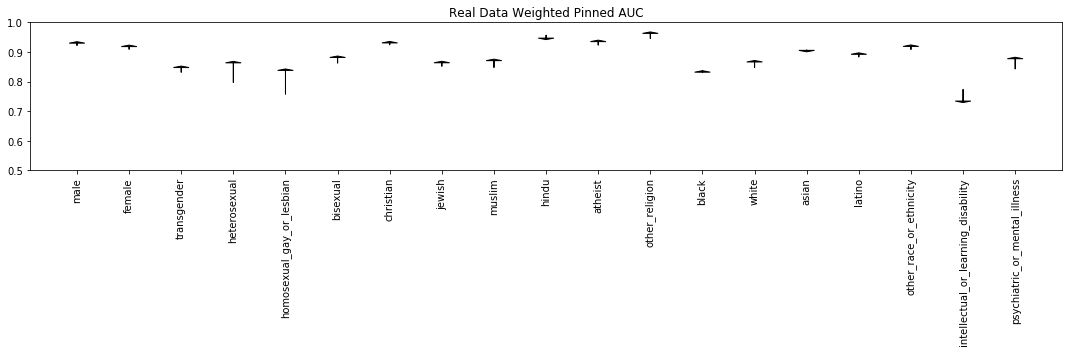

In [567]:
#scatterplot(real_data_results, 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'Real Data Pinned AUC', ylim=(0.5,1.0))
scatterplot(real_data_results, 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'Real Data Weighted Pinned AUC', ylim=(0.5,1.0))

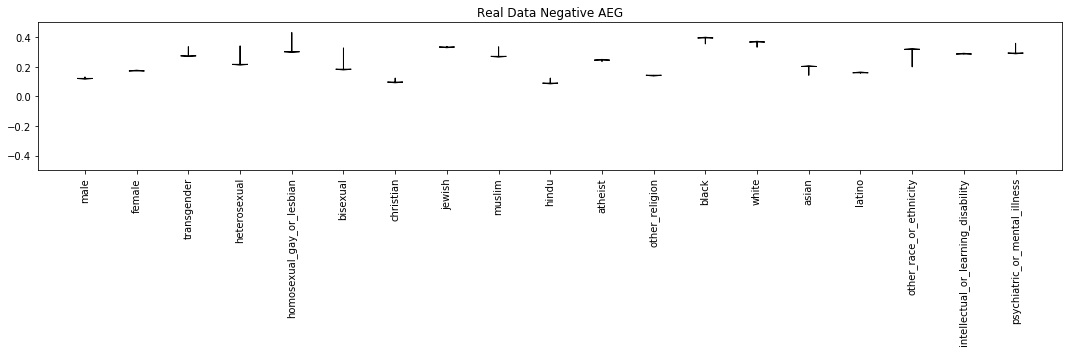

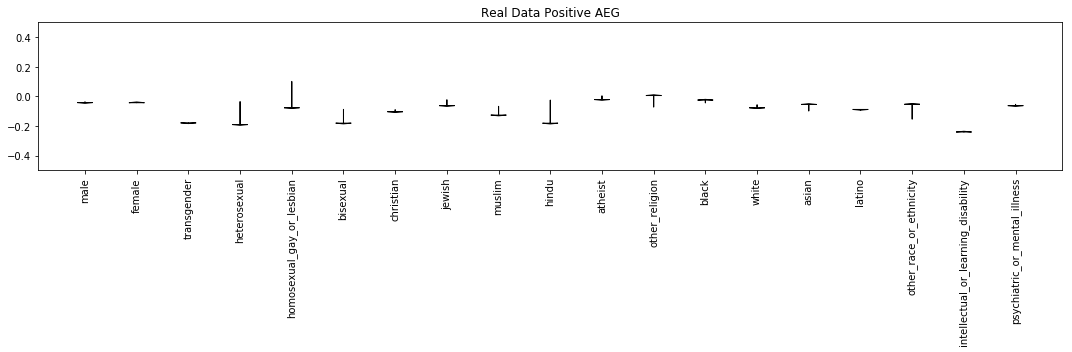

In [565]:
scatterplot(real_data_results, 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'Real Data Negative AEG', ylim=(-0.5,0.5))
scatterplot(real_data_results, 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg', 'Real Data Positive AEG', ylim=(-0.5,0.5))

In [ ]:
out = madlibs_results[['subgroup', 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg']]
out.to_csv('eval_datasets/bias_madlibs_77k_scored_prod_models_metrics.csv')

In [568]:
out_real = real_data_results[['subgroup', 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg']]
out_real.to_csv('eval_datasets/identity_labeled_metrics.csv')

In [ ]:
toxic_scores = real_data.query('toxicity == True')['rock_toxicity']
non_toxic_scores = real_data.query('toxicity == False')['rock_toxicity']
sns.distplot( non_toxic_scores , color="skyblue", axlabel='all')
sns.distplot( toxic_scores , color="red", axlabel='all')
plt.figure()

In [ ]:
toxic_scores = real_data.query('toxicity == True')['rock_v6_1_toxicity']
non_toxic_scores = real_data.query('toxicity == False')['rock_v6_1_toxicity']
sns.distplot( non_toxic_scores , color="skyblue", axlabel='all')
sns.distplot( toxic_scores , color="red", axlabel='all')
plt.figure()

In [ ]:
def plot_histogram(data, identity, model, label_col='toxicity'):
    toxic_scores = data.query(identity + ' == True & ' + label_col + ' == True')[model]
    non_toxic_scores = data.query(identity + ' == True & '+ label_col + ' == False')[model]
    sns.distplot( non_toxic_scores , color="skyblue", axlabel=identity)
    sns.distplot( toxic_scores , color="red", axlabel=identity)
    plt.figure()

In [ ]:
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_toxicity')
plot_histogram(real_data, 'homosexual_gay_or_lesbian', 'rock_v6_1_toxicity')

In [ ]:
plot_histogram(real_data, 'heterosexual', 'rock_toxicity')
plot_histogram(real_data, 'heterosexual', 'rock_v6_1_toxicity')


In [ ]:
plot_histogram(real_data, 'transgender', 'rock_toxicity')
plot_histogram(real_data, 'transgender', 'rock_v6_1_toxicity')

In [ ]:
plot_histogram(madlibs, 'homosexual', 'Rock:TOXICITY', label_col='label_bool')
#plot_histogram(madlibs, 'homosexual', 'RockV5_1:TOXICITY', label_col='label_bool')
plot_histogram(madlibs, 'homosexual', 'RockV6_1:TOXICITY', label_col='label_bool')

In [ ]:
plot_histogram(madlibs, 'gay', 'Rock:TOXICITY', label_col='label_bool')
#plot_histogram(madlibs, 'gay', 'RockV5_1:TOXICITY', label_col='label_bool')
plot_histogram(madlibs, 'gay', 'RockV6_1:TOXICITY', label_col='label_bool')

In [ ]:
real_data['diff'] = real_data['rock_v6_1_toxicity'] - real_data['rock_toxicity']

In [ ]:
look = real_data[real_data['homosexual_gay_or_lesbian'] & (real_data.comment_text.str.len() < 100)].sort_values('diff', ascending=False)[['comment_text', 'rock_v6_1_toxicity', 'rock_toxicity', 'toxicity']]

In [ ]:
pd.options.display.max_colwidth=200

In [ ]:
look[~look.toxicity]